<a href="https://colab.research.google.com/github/YY535/LFP_Simulation/blob/main/assembly_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we create 3 types of simulations, they comes from:

1.   Lopes-dos-Santos 13 JNM, Fig 3, poisson spike train with ensembles with N={n1,..} neurons increase their with uniform distribution $p \sim U[1, 6]$ at random time bins.

  Parameters:  

  * 20-(random, 2 assemblies)/32-(5 assemblies) neurons
  * simulated for of 1 spike/bin for 8000 time bins
  * spatially overlaping/non-overlaping,
  * 150/1000 simulations.
2.Brian2 based network simulation, with non-overlapping assemblies
3. Nonlinear-embedding used in pi-VAE and CEBRA.



## Lopes-dos-Santos 13 JNM linear ensembles.

Ground truth:
* background firing: spike_trains_noise;
* ensembles loading: ensembles;
* ensembles activites: activities.



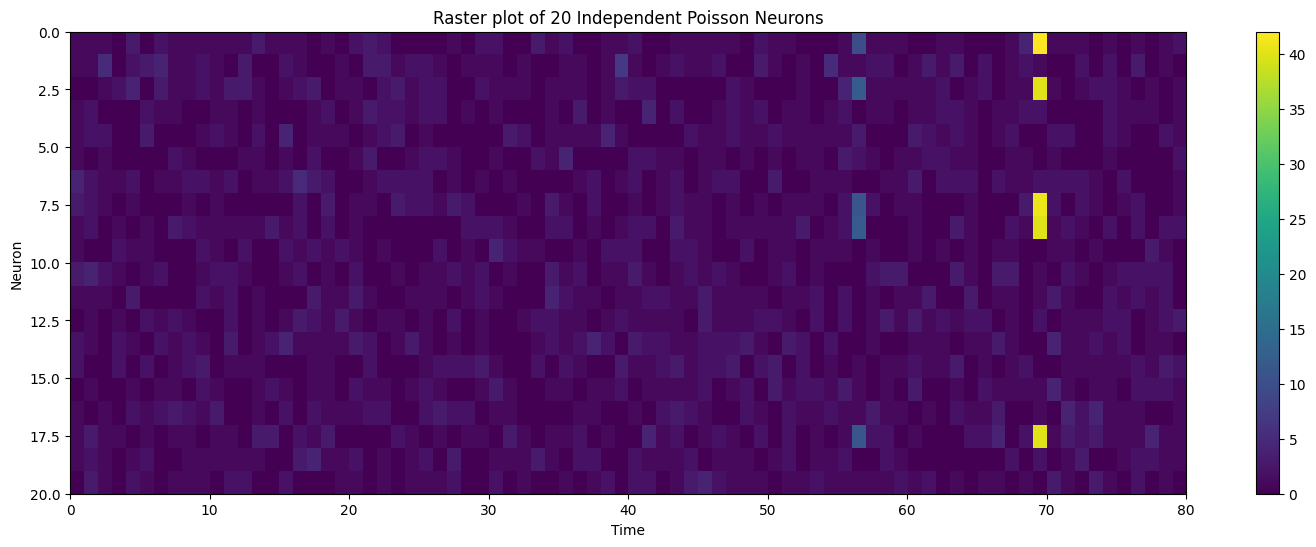

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set the number of neurons and the total length of the simulation
num_neurons = 20
total_length = 80 # 8000 is the simulation time

# Generate the  background spike trains
spike_trains_noise = np.random.poisson(lam = 1, size=(num_neurons, total_length))

# non-overlapping ensembles
tmp = np.argsort(np.random.randn(20))
ensembles = np.zeros([num_neurons,2])
ensembles[tmp[:4],0]=1.
ensembles[tmp[15:],1] = 1.
# ensembles[:4,0] = 1.
# ensembles[16:,1] = 1.

ensemble_gain = 10. # for a clear view at the ensembles. in the paper it is 1.

activitys = (np.random.uniform(0.,1.,size=[2,total_length])<.01)* np.fix(np.random.uniform(low=1.0, high=6.0, size=[2,total_length]))

spike_trains = np.dot(ensembles,activitys*ensemble_gain) +spike_trains_noise

plt.figure(figsize= [18,6])
plt.imshow(spike_trains, extent=[0, total_length, num_neurons, 0], aspect="auto")
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.title('Raster plot of 20 Independent Poisson Neurons')
plt.colorbar()
plt.show()



## Brian simulation for real neurons
simulate networks with the Brian2 simulator

In [2]:
!pip install brian2
!pip install tqdm

### Place Cells spike trains on a linear track
- Only partial of the neuron are place cells
- Place cells are placed along linear track
- This is the input to the Hopfield network.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

outfield_rate = 0.1  # avg. firing rate outside place field [Hz]
infield_rate = 5.0  # avg. in-field firing rate [Hz]
t_max = 400.0  # [s]

f_theta = 7.0  # theta osc. freq. [Hz]
v_mice = 30.43567842  # [cm/s]
l_route = 300.0  # circumference [cm]
l_place_field = 30.0  # [cm]
r = l_route / (2*np.pi)  # [cm]
phi_PF_rad = l_place_field / r  # [rad]
t_route = l_route / v_mice  # [s]
w_mice = 2*np.pi / t_route  # angular velocity

s = 47.0  # phase-locking (param of circular Gaussian)
stdanimal = 0.146  # std (param of Gaussian, defined in [0,2*np.pi])

def evaluate_lambda_t(t, phi_start, linear, phase0):
    """
    Evaluates firing rate(t, x) = tuning_curve(x) * theta_modulation(t, x) at given time points
    :param t: sample time points
    :param phi_start: starting point of the place field (in rad)
    :param linear: flag for circular vs. linear track -> slightly diff tuning curves
    :param phase0: init. phase (used to calc. phase precession)
    :return: lambda_t sampled at the given time points
    """

    x = np.mod(w_mice * t, 2*np.pi)  # positions of the mice [rad]

    if not linear:
        tau_x = get_tuning_curve_circular(x, phi_start)
    else:
        tau_x = get_tuning_curve_linear(x, phi_start)

    # theta modulation of firing rate + phase precession
    phase = phase0 + 2*np.pi * f_theta * t
    phase_shift = -np.pi / phi_PF_rad * (x - phi_start)
    theta_mod = np.cos(phase - phase_shift)

    lambda_t = tau_x * theta_mod
    lambda_t[np.where(lambda_t < 0.0)] = 0.0

    return lambda_t

def get_tuning_curve_circular(spatial_points, phi_start):
    """
    Calculates (not estimates) tuning curve (on a circle -> circular Gaussian function)
    :param spatial_points: spatial points along the circle (in rad)
    :param phi_start: starting point of the place field (in rad)
    :return: tau: tuning curve of the place cell
    """

    mid_PF = np.mod(phi_start + phi_PF_rad/2.0, 2*np.pi)
    tau = 1.0/np.exp(s) * np.exp(s*np.cos(spatial_points - mid_PF))  # circular Gaussian

    return tau


def get_tuning_curve_linear(spatial_points, phi_start):
    """
    Calculates (not estimates) tuning curve (Gaussian function)
    :param spatial_points: spatial points along the track
    :param phi_start: starting point of the place field
    :return: tau: tuning curve of the place cell
    """

    mid_PF = phi_start + phi_PF_rad/2.0
    tau = np.exp(-np.power(spatial_points-mid_PF, 2) /(2*stdanimal**2))

    return tau


def refractoriness(spike_trains, ref_per=5e-3):
    """
    Delete spikes (from generated train) which are too close to each other
    :param spike_trains: list of lists representing individual spike trains
    :param ref_per: refractory period (in sec)
    :return spike_trains: same structure, but with some spikes deleted
    """

    spike_trains_updated = []; count = 0
    for single_spike_train in spike_trains:
        tmp = np.diff(single_spike_train)  # calculate ISIs
        idx = np.where(tmp < ref_per)[0] + 1
        if idx.size:
            count += idx.size
            single_spike_train_updated = np.delete(single_spike_train, idx).tolist()  # delete spikes which are too close
        else:
            single_spike_train_updated = single_spike_train
        spike_trains_updated.append(single_spike_train_updated)

    print("%i spikes deleted becuse of too short refractory period" % count)

    return spike_trains_updated


def _generate_exp_rand_numbers(lambda_, n_rnds, seed):
    """
    MATLAB's random exponential number
    :param lambda_: normalization (will be the rate of Poisson proc - see `hom_poisson()`)
    :param n_rnds: number of random numbers to gerenerate
    :param seed: seed for random number generation
    :return: exponential random numbers
    """

    np.random.seed(seed)
    return -1.0 / lambda_ * np.log(np.random.rand(n_rnds))

def hom_poisson(lambda_, n_rnds, t_max, seed):
    """
    Generates Poisson process (interval times X_i = -ln(U_i)/lambda_, where lambda_ is the rate and U_i ~ Uniform(0,1))
    :param lambda_: rate of the Poisson process
    :param n_rnds: see `_generate_exp_rand_numbers()`
    :param t_max: length of the generate Poisson process
    :param seed: seed for random number generation (see `_generate_exp_rand_numbers()`)
    :return: poisson_proc: np.array which represent a homogenos Poisson process
    """

    rnd_isis = _generate_exp_rand_numbers(lambda_, n_rnds, seed)
    poisson_proc = np.cumsum(rnd_isis)

    assert poisson_proc[-1] > t_max, "Spike train is too short, consider increasing `n_rnds`!"
    return poisson_proc[np.where(poisson_proc <= t_max)]

def inhom_poisson(lambda_, t_max, phi_start, linear, seed, phase0=0.0):
    """
    Generates a homogeneous Poisson process and converts it to inhomogeneous
    via keeping only a subset of spikes based on the (time and space dependent) rate of the place cell (see `evaluate_lambda_t()`)
    :param lambda_: rate of the hom. Poisson process (see `hom_poisson()`)
    :param t_max: length of the generate Poisson process
    :param phi_start: starting point of the place field (see `evaluate_lambda_t()`)
    :param linear: flag for circular vs. linear track (see `evaluate_lambda_t()`)
    :param seed: seed for random number generation
    :param phase0: initial phase (see `evaluate_lambda_t()`)
    :return: inhom_poisson_proc: inhomogenos Poisson process representing the spike train of a place cell
    """

    poisson_proc = hom_poisson(lambda_, 10000, t_max, seed)  # hard coded 10000 works with 20Hz rate and 405sec spike train

    # keep only a subset of spikes
    lambda_t = evaluate_lambda_t(poisson_proc, phi_start, linear, phase0)
    np.random.seed(seed)
    inhom_poisson_proc = poisson_proc[np.where(lambda_t >= np.random.rand(poisson_proc.shape[0]))]

    return inhom_poisson_proc


def generate_spike_train(n_neurons, place_cell_ratio, linear, ordered=True, seed=12345):
    """
    Generates hippocampal like spike trains (used later for learning the weights via STDP)
    :param n_neurons: #{neurons}
    :param place_cell_ratio: ratio of place cells in the whole population
    :param linear: flag for linear vs. circular track
    :param ordered: bool to order neuronIDs based on their place fields (used for teaching 2 environments - see `stdp_2nd_env.py`)
    :param seed: starting seed for random number generation
    :return: spike_trains - list of lists with indiviual neuron's spikes
    """

    assert n_neurons >= 10, "The assumptions made during the setup hold only for a reasonably big group of neurons"

    neuronIDs = np.arange(0, n_neurons)
    # generate random neuronIDs being place cells and starting points for place fields
    if ordered:
        np.random.seed(seed)

        if linear:
            p_uniform = 1./n_neurons
            tmp = (1 - 2*2*5*p_uniform)/(n_neurons-10)
            p = np.concatenate([2*p_uniform*np.ones(5), tmp*np.ones(n_neurons-2*5), 2*p_uniform*np.ones(5)])  # slightly oversample (double prop.) the 2 ends (first and last 100 neurons) of the track
            place_cells = np.sort(np.random.choice(neuronIDs, int(n_neurons*place_cell_ratio), p=p, replace=False), kind="mergsort")
        else:
            place_cells = np.sort(np.random.choice(neuronIDs, int(n_neurons*place_cell_ratio), replace=False), kind="mergsort")
        phi_starts = np.sort(np.random.rand(n_neurons), kind="mergesort")[place_cells] * 2*np.pi

        if linear:
            phi_starts -= 0.1*np.pi  # shift half a PF against boundary effects (mid_PFs will be in [0, 2*np.pi]...)

    else:
        np.random.seed(seed+1)

        place_cells = np.random.choice(neuronIDs, int(n_neurons*place_cell_ratio), replace=False)
        phi_starts = np.sort(np.random.rand(n_neurons)[place_cells], kind="mergesort") * 2*np.pi

        if linear:
            phi_starts -= 0.1*np.pi  # shift half a PF against boundary effects (mid_PFs will be in [0, 2*np.pi]...)


    place_fields = {neuron_id:phi_starts[i] for i, neuron_id in enumerate(place_cells)}
    # save_place_fields(place_fields, pklf_name)

    # generate spike trains
    spike_trains = []
    for neuron_id in tqdm(range(0, n_neurons)):
        if neuron_id in place_fields:
            spike_train = inhom_poisson(infield_rate, t_max, place_fields[neuron_id], linear, seed)
        else:
            spike_train = hom_poisson(outfield_rate, 100, t_max, seed)
        spike_trains.append(spike_train)
        seed += 1

    return spike_trains, place_fields

In [4]:
import os, pickle
import numpy as np
from brian2 import *
from tqdm import tqdm  # prog

n_neurons = 200
place_cell_ratio = .5 #.25# 0.2
linear = True


spike_trainstmp, place_fields = generate_spike_train(n_neurons, place_cell_ratio, linear=True, ordered=True)
spike_trainstmp = refractoriness(spike_trainstmp)  # clean spike train (based on refractory period)
spike_trainstmp = np.asarray(spike_trainstmp, dtype="object")

# f_out = "spike_trains_%.1f_linear.npz"%place_cell_ratio if linear else "spike_trains_%.1f.npz"%place_cell_ratio; ordered = True
# npzf_name = os.path.join(base_path, "files", f_out)
# np.savez(npzf_name, spike_trains=spike_trainstmp)

# the input used in the later session.
spiking_neurons = 0 * np.ones_like(spike_trainstmp[0])
spike_times = np.asarray(spike_trainstmp[0])
for neuron_id in range(1, n_neurons):
    tmp = neuron_id * np.ones_like(spike_trainstmp[neuron_id])
    spiking_neurons = np.concatenate((spiking_neurons, tmp), axis=0)
    spike_times = np.concatenate((spike_times, np.asarray(spike_trainstmp[neuron_id])), axis=0)


100%|██████████| 200/200 [00:00<00:00, 1329.02it/s]

3 spikes deleted becuse of too short refractory period


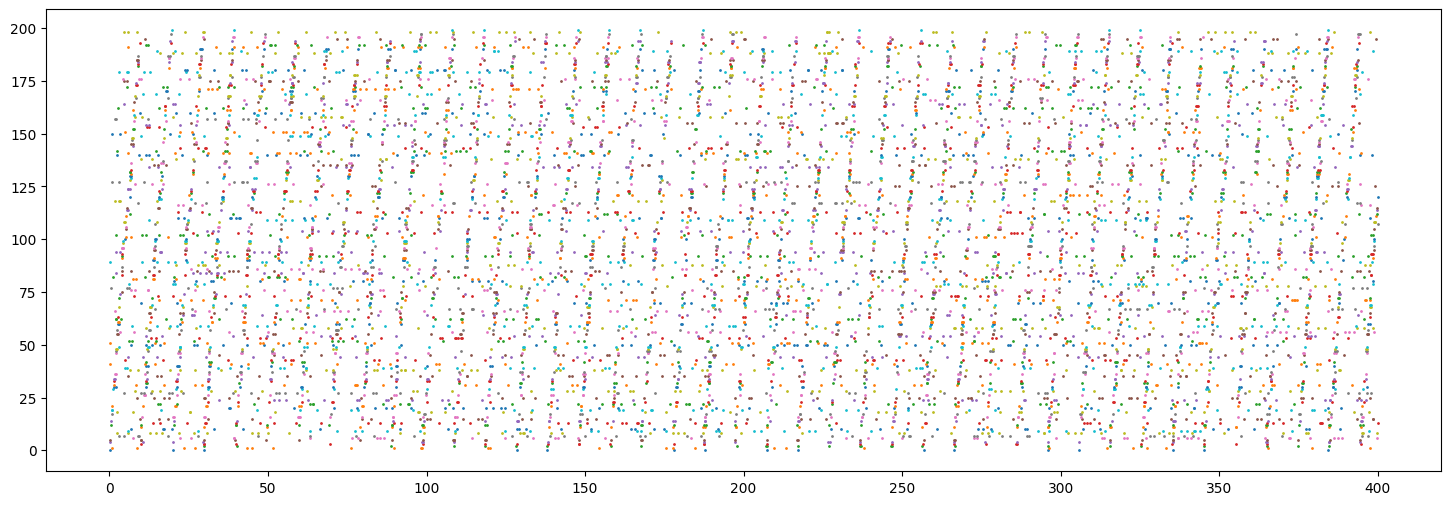

In [5]:
plt.figure(figsize= [18,6])
kk = 0.
for xx in spike_trainstmp:
    plt.plot(xx, kk*np.ones_like(xx), '.', markersize=2)
    kk+=1.
plt.show()


### Generate random connectivity matrix


In [6]:
from scipy.sparse import coo_matrix
connection_prob_PC = .1
weightmx = np.random.rand(n_neurons, n_neurons)
weightmx[weightmx>connection_prob_PC] = 0.0
np.fill_diagonal(weightmx, 0.0)  # just to make sure
sparse_weightmx = coo_matrix(weightmx)

### Run simulation with a large network contains nclus non-overlaping assemblies.
- nclu = 10
- initial connectivity matrix, not quite useful in this case: intsparse_weightmx=sparse_weightmx,
- intra-assembly connectivity strength: intweight=50.
- extra input strength: extweight = 50.
-  to set the poisson noises by external stimuli:
```
rate = 3 * Hz
C_ext = 800  
    ```

if the entra input strength is larger, then the neuron will fire more following the inputs at exact position, you'll see similar P cell firing pattern as the input pattern.

if the intra input strength is larger, then the neuron will fire when the assembly is activated, performing pattern completion. You'll see more reliably assembly patterns.

- You can play with the assembly by defining different connectivity matrix weights

In [7]:
import random
import copy as cp

def runsimulation(nPC, inputneurons,inputspk,nclu = 10,intsparse_weightmx=sparse_weightmx,intweight=55.,extweight = 50.):
    # voltage
    N_E = nPC
    N_I = 10 # 100
    V_L = -70. * mV
    V_thr = -50. * mV
    V_reset = -55. * mV
    V_E = 0. * mV
    V_I = -70. * mV

    # membrane capacitance
    C_m_E = 0.5 * nF
    C_m_I = 0.2 * nF

    # membrane leak
    g_m_E = 25. * nS
    g_m_I = 20. * nS

    # refractory period
    tau_rp_E = 2. * ms
    tau_rp_I = 1. * ms

    # external stimuli
    rate = 3 * Hz
    C_ext = 800 # 800

    # synapses
    C_E = N_E
    C_I = N_I

    # AMPA (excitatory)
    g_AMPA_ext_E = 2.08 * nS
    g_AMPA_rec_E = 0.104 * nS * 800. / N_E
    g_AMPA_ext_I = 1.62 * nS
    g_AMPA_rec_I = 0.081 * nS * 800. / N_E
    tau_AMPA = 2. * ms

    # NMDA (excitatory)
    g_NMDA_E = 0.327 * nS * 800. / N_E
    g_NMDA_I = 0.258 * nS * 800. / N_E
    tau_NMDA_rise = 2. * ms
    tau_NMDA_decay = 100. * ms
    alpha = 0.5 / ms
    Mg2 = 1.

    # GABAergic (inhibitory)
    g_GABA_E = 1.25 * nS * 200. / N_I *4.
    g_GABA_I = 0.973 * nS * 200. / N_I
    tau_GABA = 10. * ms

    # subpopulations
    f = 0.1
    p = 5
    N_sub = int(N_E * f)
    N_non = int(N_E * (1. - f * p))
    w_plus = 2.1
    w_minus = 1. - f * (w_plus - 1.) / (1. - f)

    # modeling
    eqs_E = '''
    dv / dt = (- g_m_E * (v - V_L) - I_syn) / C_m_E : volt (unless refractory)

    I_syn = I_AMPA_ext + I_AMPA_rec + I_NMDA_rec + I_GABA_rec : amp

    I_AMPA_ext = g_AMPA_ext_E * (v - V_E) * s_AMPA_ext : amp
    I_AMPA_rec = g_AMPA_rec_E * (v - V_E) * 1 * s_AMPA : amp
    ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
    ds_AMPA / dt = - s_AMPA / tau_AMPA : 1

    I_NMDA_rec = g_NMDA_E * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
    s_NMDA_tot : 1

    I_GABA_rec = g_GABA_E * (v - V_I) * s_GABA : amp
    ds_GABA / dt = - s_GABA / tau_GABA : 1

    '''

    eqs_I = '''
    dv / dt = (- g_m_I * (v - V_L) - I_syn) / C_m_I : volt (unless refractory)

    I_syn = I_AMPA_ext + I_AMPA_rec + I_NMDA_rec + I_GABA_rec : amp

    I_AMPA_ext = g_AMPA_ext_I * (v - V_E) * s_AMPA_ext : amp
    I_AMPA_rec = g_AMPA_rec_I * (v - V_E) * 1 * s_AMPA : amp
    ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
    ds_AMPA / dt = - s_AMPA / tau_AMPA : 1

    I_NMDA_rec = g_NMDA_I * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
    s_NMDA_tot : 1

    I_GABA_rec = g_GABA_I * (v - V_I) * s_GABA : amp
    ds_GABA / dt = - s_GABA / tau_GABA : 1
    '''

    P_E = NeuronGroup(N_E, eqs_E, threshold='v > V_thr', reset='v = V_reset', refractory=tau_rp_E, method='euler')
    P_E.v = V_L
    P_I = NeuronGroup(N_I, eqs_I, threshold='v > V_thr', reset='v = V_reset', refractory=tau_rp_I, method='euler')
    P_I.v = V_L


    eqs_glut = '''
    s_NMDA_tot_post = w * s_NMDA : 1 (summed)
    ds_NMDA / dt = - s_NMDA / tau_NMDA_decay + alpha * x * (1 - s_NMDA) : 1 (clock-driven)
    dx / dt = - x / tau_NMDA_rise : 1 (clock-driven)
    w : 1
    '''


    eqs_pre_glut = '''
    s_AMPA += w
    x += 1
    '''

    eqs_pre_gaba = '''
    s_GABA += 1
    '''

    eqs_pre_ext = '''
    s_AMPA_ext += extweight
    '''
    # 1

    # E to E
    C_E_E = Synapses(P_E, P_E, model=eqs_glut, on_pre=eqs_pre_glut, method='euler')

    C_E_E.connect(i=intsparse_weightmx.row, j=intsparse_weightmx.col)
    C_E_E.w=intsparse_weightmx.data*.5


    nclut = int(floor(nPC/nclu))
    for xclu in range(nclu):
        # print((x*nclut))
        C_E_E.w[(xclu*nclut):((xclu+1)*nclut-1),(xclu*nclut):((xclu+1)*nclut-1)]+=intweight # *=50.

    for n in range(nPC):
        C_E_E.w[n,n]=0.0

    # E to I
    C_E_I = Synapses(P_E, P_I, model=eqs_glut, on_pre=eqs_pre_glut, method='euler')
    C_E_I.connect()
    C_E_I.w[:] = 1

    # I to I
    C_I_I = Synapses(P_I, P_I, on_pre=eqs_pre_gaba, method='euler')
    C_I_I.connect('i != j')

    # I to E
    C_I_E = Synapses(P_I, P_E, on_pre=eqs_pre_gaba, method='euler')
    C_I_E.connect()

    # external noise
    C_P_E = PoissonInput(P_E, 's_AMPA_ext', C_ext, rate, '1')
    C_P_I = PoissonInput(P_I, 's_AMPA_ext', C_ext, rate, '1')


    INPC = SpikeGeneratorGroup(nPC, inputneurons,inputspk)
    feedforward = Synapses(INPC, P_E, on_pre=eqs_pre_ext)
    feedforward.connect(j='i')

    SM_PC = SpikeMonitor(P_E)
    # state_mon = StateMonitor(P, 'v', record=True)
    SM_PV = SpikeMonitor(P_I, 'v', record=True)
    run(50*second,report="text")
    return SM_PC, SM_PV
    # return SM_PC,state_mon

spiking_neuronstmp_ = cp.deepcopy(spiking_neurons)
random.shuffle(spiking_neuronstmp_)
# SM_PC,SM_PV= runsimulation(n_neurons,spiking_neuronstmp_,spike_times*second)
SM_PC, SM_PV= runsimulation(n_neurons,spiking_neurons[::2],spike_times[::2]*second)

Starting simulation at t=0. s for a duration of 50. s
2.5305 s (5%) simulated in 10s, estimated 3m 8s remaining.
4.8537 s (9%) simulated in 20s, estimated 3m 6s remaining.
7.8651 s (15%) simulated in 30s, estimated 2m 41s remaining.
12.0355 s (24%) simulated in 40s, estimated 2m 6s remaining.
13.8891 s (27%) simulated in 50s, estimated 2m 10s remaining.
15.3907 s (30%) simulated in 1m 0s, estimated 2m 15s remaining.
18.4012 s (36%) simulated in 1m 10s, estimated 2m 0s remaining.
21.6048 s (43%) simulated in 1m 20s, estimated 1m 45s remaining.
24.874 s (49%) simulated in 1m 30s, estimated 1m 31s remaining.
27.984 s (55%) simulated in 1m 40s, estimated 1m 19s remaining.
30.5446 s (61%) simulated in 1m 50s, estimated 1m 10s remaining.
33.37 s (66%) simulated in 2m 0s, estimated 1m 0s remaining.
36.1095 s (72%) simulated in 2m 10s, estimated 50s remaining.
38.6667 s (77%) simulated in 2m 20s, estimated 41s remaining.
41.3176 s (82%) simulated in 2m 30s, estimated 32s remaining.
43.942 s (8

Hopfield network will "complete" the pattern even if you just see part of it. To play with it, you can:
- shuffle the spike trains
- change the weight of inter cluster connection
- change the input strength
To see the "blocks"


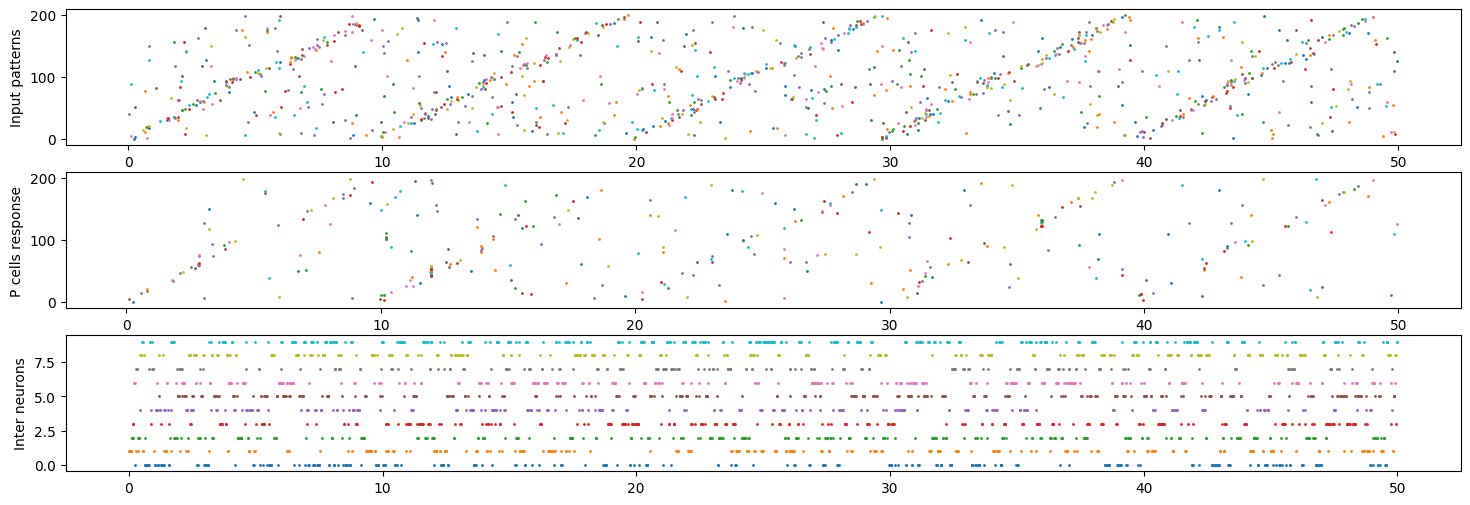

In [8]:
spiketrainsP=SM_PC.spike_trains()
plt.figure(figsize= [18,6])
plt.subplot(311)
kk = 0
upt = 50. # range of time you want to see.
for xx in spike_times:
    plt.plot(xx[xx<upt], spiking_neurons[kk]*np.ones_like(xx[xx<upt]), '.', markersize=2)
    kk+=1
plt.ylabel('Input patterns')
plt.subplot(312)
kk = 0.
for xx in spiketrainsP:
    tmp = np.array(spiketrainsP[xx])
    plt.plot(tmp[tmp<upt], kk*np.ones_like(tmp[tmp<upt]), '.', markersize=2)
    kk+=1.
plt.ylabel('P cells response')
plt.subplot(313)
spiketrainsP=SM_PV.spike_trains()
kk = 0.
for xx in spiketrainsP:
    tmp = np.array(spiketrainsP[xx])
    plt.plot(tmp[tmp<upt], kk*np.ones_like(tmp[tmp<upt]), '.', markersize=2)
    kk+=1.
plt.ylabel('Inter neurons')
plt.show()

## Variations

### Generate connectivity to memorize current input sequences.
- generate the stdp trained weight matrix. it could be used to train a sequence generator/ring attractor.
- Not used in the simple hebbian attracor.

In [5]:
from scipy.sparse import coo_matrix
connection_prob_PC = .1
# w_init = .01
# taup = taum = 20 * ms
# Ap = 0.01
# Am = -Ap
# wmax = 4e-8  # S
taup = taum = 62.5 * ms
Ap = Am = 4e-3
wmax = 2e2 # 2e-8  # S
scale_factor = 0.62
w_init = 1e-6  # S
Ap *= wmax
Am *= wmax  #


def generate_wmx(nPCs,spiking_neurons,spike_times):
    PC = SpikeGeneratorGroup(nPCs, spiking_neurons, spike_times)
    STDP = Synapses(PC, PC,
              """
              w : 1
              dA_presyn/dt = -A_presyn/taup : 1 (event-driven)
              dA_postsyn/dt = -A_postsyn/taum : 1 (event-driven)
              """,
              on_pre="""
              A_presyn += Ap
              w = clip(w + A_postsyn, 0, wmax)
              """,
              on_post="""
              A_postsyn += Am
              w = clip(w + A_presyn, 0, wmax)
              """)
    STDP.connect(condition="i!=j", p=connection_prob_PC)
    STDP.w = w_init
    run(20*second, report="text")

    weightmx = np.zeros((nPCs, nPCs))
    weightmx[STDP.i[:], STDP.j[:]] = STDP.w[:]
    np.fill_diagonal(weightmx, 0.0)  # just to make sure
    sparse_weightmx = coo_matrix(weightmx)
    return sparse_weightmx

sparse_weightmx = generate_wmx(n_neurons,spiking_neurons,spike_times*second)

Starting simulation at t=0. s for a duration of 20. s
20. s (100%) simulated in 9s


## pi-VAE and CEBRA  nonlinear embeddings

need to download the pi-VAE file.

In [2]:
!pip install keras
!pip install tensorflow


In [10]:
from pi_vae import *

num_neurons = 20
total_length = 80
n_cls = 2

z_true, u_true, mean_true, lam_true = simulate_data(total_length, n_cls, num_neurons);
np.random.seed(777)
x_true = np.random.poisson(lam_true)

3/3 [==============================] - 1s 10ms/step


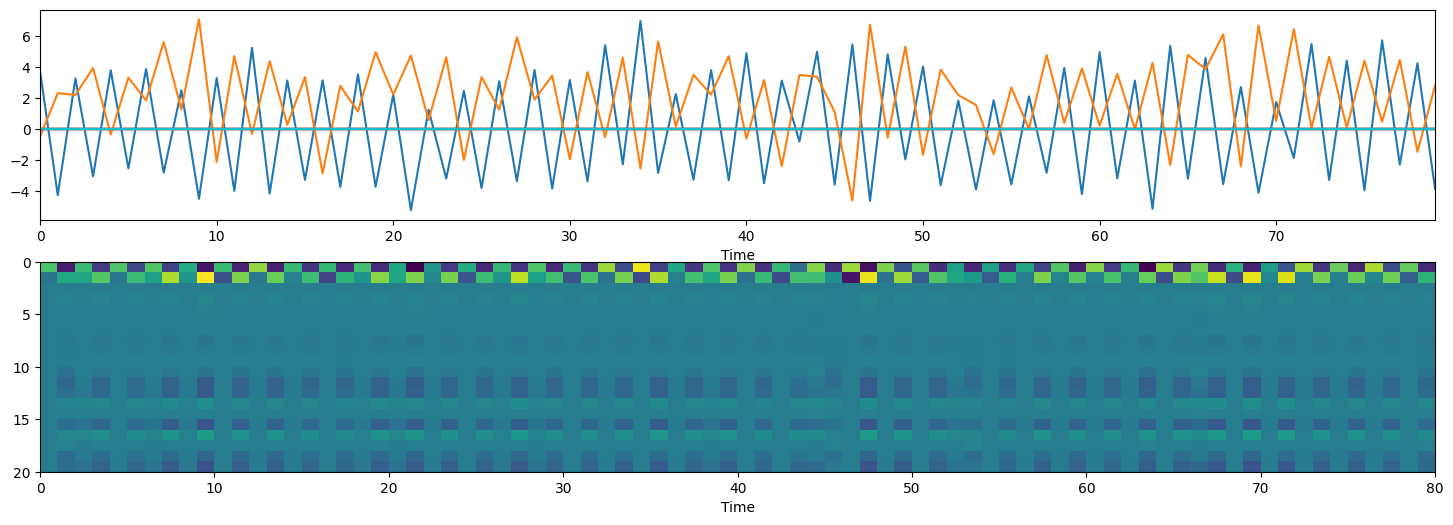

In [ ]:
plt.figure(figsize= [18,6])
plt.subplot(211)
plt.plot(z_true)
plt.xlabel('Time')
plt.autoscale(enable=True, axis='x', tight=True)
plt.subplot(2,1,2)
plt.imshow(mean_true.transpose(), extent=[0, total_length, num_neurons, 0], aspect="auto")
plt.xlabel('Time')
plt.show()

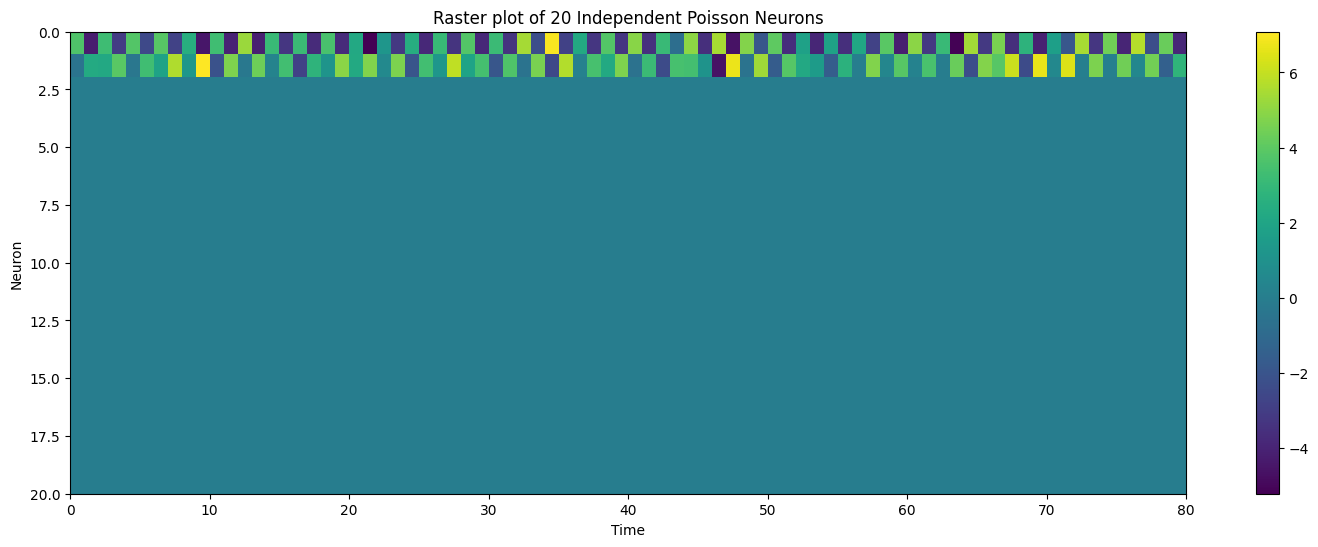

In [ ]:
plt.figure(figsize= [18,6])
plt.imshow(z_true.transpose(), extent=[0, total_length, num_neurons, 0], aspect="auto")
plt.xlabel('Time')
plt.ylabel('Neuron')
plt.title('Raster plot of 20 Independent Poisson Neurons')
plt.colorbar()
plt.show()



Realistic neurons